# Ch 6. 集成學習
[6-1. 以袋裝法集思廣益(Bagging)](#sec6_1)  
[6-2. 以提升法互補有無(Boosting)](#sec6_2)  
[6-3. 以堆疊法兼容並蓄(Stacking)](#sec6_3)  
***

<a id='sec6_1'></a>
## 6-1. 以袋裝法集思廣益(Bagging)

In [1]:
import pandas as pd

df = pd.read_csv('Pokemon_894_12.csv')
df['hasType2'] = [0 if x else 1 for x in df['Type2'].isna()]
df.head(5)

,Number,Name,Type1,Type2,HP,Attack,Defense,SpecialAtk,SpecialDef,Speed,Generation,Legendary,hasType2
0,1,妙蛙種子,Grass,Poison,45,49,49,65,65,45,1,False,1
1,2,妙蛙草,Grass,Poison,60,62,63,80,80,60,1,False,1
2,3,妙蛙花,Grass,Poison,80,82,83,100,100,80,1,False,1
3,3,妙蛙花Mega,Grass,Poison,80,100,123,122,120,80,1,False,1
4,4,小火龍,Fire,NaN,39,52,43,60,50,65,1,False,0


In [2]:
from sklearn.model_selection import train_test_split

X, y = df.loc[:, 'HP':'Speed'], df['hasType2']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=0)
X_train.shape

(670, 6)

In [3]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

models = {'KNN': KNeighborsClassifier(n_neighbors=3), 
          'bagging': BaggingClassifier(KNeighborsClassifier(n_neighbors=3), 
                                       n_estimators=3, 
                                       max_samples=.8, 
                                       max_features=.8, 
                                       n_jobs=-1, 
                                       random_state=0)}
scores = {}
for name, clf in models.items():
    clf.fit(X_train, y_train)
    scores[(name, 'Train score')] = clf.score(X_train, y_train)
    scores[(name, 'Test score')] = clf.score(X_test, y_test)
    
pd.Series(scores).unstack()

,Test score,Train score
KNN,0.562500,0.804478
bagging,0.580357,0.722388


<a id='sec6_2'></a>
## 6-2. 以提升法互補有無(Boosting)

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

models = {'Decision Tree': DecisionTreeClassifier(max_depth=1), 
          'AdaBoost': AdaBoostClassifier(n_estimators=3, 
                                         random_state=0)}

scores = {}
for name, clf in sorted(models.items(), key=lambda x:x[0], reverse=True):
    clf.fit(X_train, y_train)
    scores[(name, 'Train score')] = clf.score(X_train, y_train)
    scores[(name, 'Test score')] = clf.score(X_test, y_test)
    
pd.Series(scores).unstack().sort_index(ascending=False)

,Test score,Train score
Decision Tree,0.616071,0.607463
AdaBoost,0.633929,0.607463


In [5]:
X_r, y_r = df.loc[:, 'Attack':'Speed'], df['HP']
X_r_train, X_r_test, y_r_train, y_r_test = \
    train_test_split(X_r, y_r, test_size=0.25, random_state=0)
X_r_train.shape

(670, 5)

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

reg = DecisionTreeRegressor(max_depth=3)
models = {'Decision Tree': reg, 
          'AdaBoost': AdaBoostRegressor(reg, learning_rate=.01, 
                                        random_state=0)}

scores = {}
for name, clf in sorted(models.items(), key=lambda x:x[0], reverse=True):
    clf.fit(X_r_train, y_r_train)
    scores[(name, 'Train score')] = clf.score(X_r_train, y_r_train)
    scores[(name, 'Test score')] = clf.score(X_r_test, y_r_test)
    
pd.Series(scores).unstack().sort_index(ascending=False)

,Test score,Train score
Decision Tree,0.226408,0.413383
AdaBoost,0.339387,0.446392


<a id='sec6_3'></a>
## 6-3. 以堆疊法兼容並蓄(Stacking)
#### Voting

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = GaussianNB()

en_clf1 = VotingClassifier(estimators=[
    ('lr', clf1), ('rf', clf2), ('nb', clf3)], 
                           voting='hard')

en_clf1.fit(X_train, y_train)
en_clf1.predict(X_test)[:10]

array([1, 1, 1, 0, 1, 1, 0, 0, 1, 1], dtype=int64)

In [8]:
# 記錄準確率
scores = {}
name = 'Voting (hard)'
scores[(name, 'Train score')] = en_clf1.score(X_train, y_train)
scores[(name, 'Test score')] = en_clf1.score(X_test, y_test)

# 取出每個模型的分類結果
print('真實類別：', y_test[:10].values)
print('邏輯斯迴歸分類結果：', en_clf1.named_estimators_['lr'].predict(X)[:10])
print('隨機森林分類結果：', en_clf1.named_estimators_['rf'].predict(X)[:10])

真實類別： [1 1 0 0 1 1 1 0 0 1]
邏輯斯迴歸分類結果： [0 0 1 1 0 0 1 1 1 0]
隨機森林分類結果： [1 0 1 1 0 0 1 1 1 0]


In [9]:
en_clf2 = VotingClassifier(estimators=[
    ('lr', clf1), ('rf', clf2), ('gnb', clf3)], 
                           voting='soft')
en_clf2.fit(X_train, y_train)
en_clf2.predict(X_test)[:10]

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 1], dtype=int64)

In [10]:
name = 'Voting (soft)'
scores[(name, 'Train score')] = en_clf2.score(X_train, y_train)
scores[(name, 'Test score')] = en_clf2.score(X_test, y_test)

# 取出每個模型的預測機率
prob = en_clf2.transform(X_test)
print('真實類別：', y_test.iloc[0])
print('邏輯斯迴歸分類機率：', prob[0][:2])
print('隨機森林分類機率：', prob[0][2:4])
print('單純貝氏分類機率：', prob[0][4:])

真實類別： 1
邏輯斯迴歸分類機率： [0.35726441 0.64273559]
隨機森林分類機率： [0.42716667 0.57283333]
單純貝氏分類機率： [0.43394856 0.56605144]


In [11]:
en_clf3 = VotingClassifier(estimators=[
    ('lr', clf1), ('rf', clf2), ('gnb', clf3)], 
                           voting='soft', weights=[2,1,1])
en_clf3.fit(X_train, y_train)
en_clf3.predict(X_test)[:10]

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 1], dtype=int64)

In [12]:
name = 'Voting (soft + weight)'
scores[(name, 'Train score')] = en_clf3.score(X_train, y_train)
scores[(name, 'Test score')] = en_clf3.score(X_test, y_test)

pd.Series(scores).unstack().sort_index(ascending=True)

,Test score,Train score
Voting (hard),0.589286,0.661194
Voting (soft + weight),0.598214,0.791045
Voting (soft),0.607143,0.849254


#### Stacking

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(max_depth=7, random_state=0)
clf3 = GaussianNB()

lr = LogisticRegression()
estimators = [('K-NN', clf1), ('rf', clf2), ('nb', clf3)]
sclf = StackingClassifier(estimators=estimators, 
                          final_estimator=lr, n_jobs=-1)
titles = ('K-NN', 'Random Forest', 'Naive Bayes',
          'Stacking')

models = (clf1, clf2, clf3, sclf)
models = [clf.fit(X_train, y_train) for clf in models]

scores = {}
for clf, title in zip(models, titles):
    scores[(title, 'Train score')] = clf.score(X_train, y_train)
    scores[(title, 'Test score')] = clf.score(X_test, y_test)

pd.Series(scores).unstack().sort_index(ascending=True)

,Test score,Train score
K-NN,0.575893,0.995522
Naive Bayes,0.611607,0.576119
Random Forest,0.562500,0.888060
Stacking,0.620536,0.907463


In [14]:
for i, est in enumerate(estimators):
    print(est[0], '的權重 =', sclf.final_estimator_.coef_[0][i])

K-NN 的權重 = 0.4070787575559543
rf 的權重 = 0.8704445947940478
nb 的權重 = 0.9177966370470659


In [15]:
# 繪製學習曲線
import numpy as np
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=sclf, X=X_train, y=y_train, 
                   train_sizes=np.linspace(0.1, 1.0, 10), 
                   cv=10, n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
test_mean

array([0.49104478, 0.50149254, 0.52985075, 0.51791045, 0.57014925,
       0.57761194, 0.58208955, 0.59850746, 0.60149254, 0.60298507])

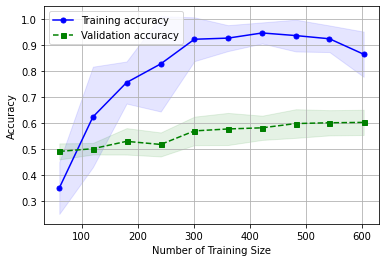

In [16]:
import matplotlib.pyplot as plt

plt.plot(train_sizes, train_mean, color='blue', marker='o', 
         markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, 
                 train_mean + train_std, 
                 train_mean - train_std, 
                 alpha=.1, color='blue')
plt.plot(train_sizes, test_mean, color='green', ls='--',
         marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, 
                 test_mean + test_std, 
                 test_mean - test_std, 
                 alpha=.1, color='green')
plt.grid()
plt.xlabel('Number of Training Size')
plt.ylabel('Accuracy')
plt.legend();